# Basic Models in TensorFlow 

## Logistic Regression with ce loss
- Dataset: MNIST 

### Setup 

In [5]:
from __future__ import absolute_import, division, print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

print(tf.__version__)

1.12.0


### Load and Pre-process data 

In [10]:
(x_train, y_train), (x_tst, y_tst) = tf.keras.datasets.mnist.load_data()
x_train = x_train/255 # Normalization
x_train = x_train.reshape(-1, 784) # 2D --> 1D
x_tst = x_tst/255
x_tst = x_tst.reshape(-1, 784)

In [14]:
print('x_train.shape: {} \ny_train.shape: {}'.format(x_train.shape, y_train.shape))
print('x_tst.shape: {} \ny_tst.shape: {}'.format(x_tst.shape, y_tst.shape))

x_train.shape: (60000, 784) 
y_train.shape: (60000,)
x_tst.shape: (10000, 784) 
y_tst.shape: (10000,)


In [18]:
tr_indices = np.random.choice(range(x_train.shape[0]), size=55000, replace=False)

x_tr = x_train[tr_indices]
y_tr = y_train[tr_indices]

# x_train중에서 random값으로 뽑은 tr_indices값을 행(axis=0)을 기준으로 delete
x_val = np.delete(arr=x_train, obj=tr_indices, axis=0)
y_val = np.delete(arr=y_train, obj=tr_indices, axis=0)

print('x_tr.shape: {} \ny_tr.shape: {}'.format(x_tr.shape, y_tr.shape))
print('x_val.shape: {} \ny_val.shape: {}'.format(x_val.shape, y_val.shape))

x_tr.shape: (55000, 784) 
y_tr.shape: (55000,)
x_val.shape: (5000, 784) 
y_val.shape: (5000,)


### Define the graph of Softmax Classifier

In [21]:
print(x_tr.dtype)
print(y_tr.dtype)

float64
uint8


In [37]:
tf.reset_default_graph()

# Create placeholders for x(birth rate) and y(life expectancy)
x = tf.placeholder(dtype=tf.float32, shape=[None, 784])
y = tf.placeholder(dtype=tf.int32, shape=[None])

# Create weight and bias, initialized to 0
w = tf.get_variable(name='weights', shape=[784, 10], dtype=tf.float32,
                   initializer=tf.contrib.layers.xavier_initializer())
b = tf.get_variable(name='bias', shape=[10], dtype=tf.float32,
                   initializer=tf.zeros_initializer())

# Construct model 
score = tf.matmul(x, w) + b

# Use the cross entropy as loss function
ce_loss = tf.reduce_mean(tf.losses.sparse_softmax_cross_entropy(labels=y, logits=score))
ce_loss_summ = tf.summary.scalar(name='ce_loss', tensor=ce_loss) # for tensorboard

# Using gradient descent with learning rate of 0.01 to minimize loss
opt = tf.train.GradientDescentOptimizer(learning_rate=.01)
training_op = opt.minimize(ce_loss)

### Training 

In [26]:
epochs = 30
batch_size = 64
total_step = int(x_tr.shape[0]/batch_size)
print(total_step)

859


In [28]:
# For using tensorboard 
train_writer = tf.summary.FileWriter(logdir='../graphs/lec03/logreg_tf_placholder/train',
                                    graph=tf.get_default_graph())
val_writer = tf.summary.FileWriter(logdir='../graphs/lec03/logreg_tf_placeholder/val',
                                  graph=tf.get_default_graph())

In [38]:
%time
sess = tf.Session()
sess.run(tf.global_variables_initializer())

tr_loss_hist = []
val_loss_hist = []

for epoch in range(epochs):
    avg_tr_loss = 0
    avg_val_loss = 0
    
    for step in range(total_step):
        
        batch_indices = np.random.choice(range(x_tr.shape[0]), size=batch_size, replace=False)
        val_indices = np.random.choice(range(x_val.shape[0]), size=batch_size, replace=False)
        
        batch_xs = x_tr[batch_indices]
        batch_ys = y_tr[batch_indices]
        val_xs = x_val[val_indices]
        val_ys = y_val[val_indices]
        
        _, tr_loss = sess.run(fetches=[training_op, ce_loss],
                        feed_dict={x: batch_xs, y: batch_ys})
        tr_loss_summ = sess.run(ce_loss_summ, feed_dict={x: batch_xs, y: batch_ys})
        
        val_loss, val_loss_summ = sess.run(fetches=[ce_loss, ce_loss_summ],
                                          feed_dict={x: val_xs, y:val_ys})
        avg_tr_loss += tr_loss / total_step
        avg_val_loss += val_loss / total_step
        
    tr_loss_hist.append(avg_tr_loss)
    val_loss_hist.append(avg_val_loss)
    train_writer.add_summary(tr_loss_summ, global_step=epoch)
    val_writer.add_summary(val_loss_summ, global_step=epoch)
    
    if(epoch + 1) % 5 == 0:
        print('epoch: {:3}, tr_loss: {:.2f}, val_loss: {:.2f}'.format(epoch+1, avg_tr_loss, avg_val_loss))

train_writer.close()
val_writer.close()

epoch:   5, tr_loss: 0.42, val_loss: 0.36
epoch:  10, tr_loss: 0.36, val_loss: 0.30
epoch:  15, tr_loss: 0.34, val_loss: 0.27
epoch:  20, tr_loss: 0.33, val_loss: 0.26
epoch:  25, tr_loss: 0.31, val_loss: 0.25
epoch:  30, tr_loss: 0.30, val_loss: 0.24


### Visualization

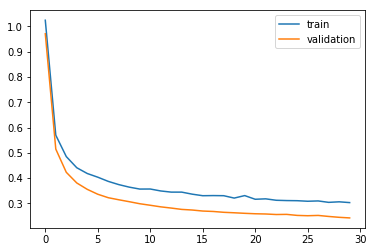

In [39]:
plt.plot(tr_loss_hist, label='train')
plt.plot(val_loss_hist, label='validation')
plt.legend()

In [42]:
yhat = np.argmax(sess.run(score, feed_dict={x: x_tst}), axis=1)
print('acc: {:.2%}'.format(np.mean(yhat == y_tst)))

acc: 91.74%
